# KPrototypes

KMeans only works with numerical data. Since our dataset has a lot of categorical variables that we can exploit, we decided to try a variation of KMeans known as KPrototypes instead that offers support for both numerical and categorical data. 

KPrototypes is not available in `scikit-learn` but is available via the `kmodes` library.

**Setting up**

In [1]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

[04/19/23 02:57:43] INFO     Resolved project path as: /home/eckt/Documents/usg.                    ]8;id=134632;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=765969;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/19/23 02:57:45] INFO     Kedro project usg                                                      ]8;id=186241;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=442048;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=211747;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=382109;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

[04/19/23 02:57:47] INFO     Registered line magic 'run_viz'                                        ]8;id=8044;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=527982;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#110\110]8;;\

In [2]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [3]:
X = catalog.load('train').set_index('appid')
X.describe().round(2)

[04/19/23 02:57:54] INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=319505;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=817961;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,mac,linux,Multi-player,Steam Achievements,Steam Trading Cards,Indie,Action,Casual,Strategy,Simulation,...,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
count,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,...,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00,27075.00
mean,0.30,0.19,0.15,0.52,0.29,0.72,0.44,0.38,0.19,0.19,...,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
std,0.46,0.39,0.35,0.50,0.45,0.45,0.50,0.48,0.40,0.39,...,1.97,1.22,1.07,0.94,0.91,0.75,0.67,0.63,0.48,0.32
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-3.35,-5.26,-4.01,-2.75,-3.01,-3.01,-2.82,-3.07,-1.95,-1.40
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.46,-0.89,-0.73,-0.74,-0.62,-0.46,-0.42,-0.42,-0.25,-0.16
50%,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,-0.38,-0.00,-0.09,-0.03,-0.02,-0.04,0.01,0.05,0.03,-0.01
75%,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,...,1.10,0.87,0.62,0.64,0.56,0.43,0.37,0.43,0.28,0.11
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,8.52,5.36,8.44,3.62,5.74,6.04,4.01,3.08,3.67,1.89


# Finding best number of clusters using elbow method

In [11]:
def cluster(k=1):
  model = KPrototypes(n_clusters = k, n_jobs = -2, random_state = 0)
  model.fit_predict(X, categorical=list(range(0, len(categorical))))
  return model

In [17]:
cost = []
for k in range(1, 100):
    try:
        log.info("Performing clustering for k=%d", k)
        model = cluster(k)
        cost.append(model.cost_)
        log.info("k=%d, cost=%d, n_iter=%d", k, model.cost_, model.n_iter_)
    except KeyboardInterrupt:
        break
cost

[04/18/23 11:17:35] INFO     Performing clustering for k=1                                          ]8;id=334589;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=859322;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:17:54] INFO     k=1, cost=307018, n_iter=1                                             ]8;id=197584;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=273102;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=2                                          ]8;id=390287;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=140608;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:19:50] INFO     k=2, cost=232174, n_iter=10                                            ]8;id=650478;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=410082;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=3                                          ]8;id=853013;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=8071;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:23:23] INFO     k=3, cost=202812, n_iter=23                                            ]8;id=70556;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=729820;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=4                                          ]8;id=314604;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=893267;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:28:02] INFO     k=4, cost=187008, n_iter=18                                            ]8;id=475285;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=115811;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=5                                          ]8;id=753253;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=717181;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:33:59] INFO     k=5, cost=175946, n_iter=22                                            ]8;id=806121;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=862346;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=6                                          ]8;id=964367;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=298890;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:45:14] INFO     k=6, cost=167520, n_iter=19                                            ]8;id=322003;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=46111;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=7                                          ]8;id=523881;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=246319;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 11:58:40] INFO     k=7, cost=159616, n_iter=67                                            ]8;id=73653;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=920836;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=8                                          ]8;id=362892;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=942019;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 12:09:31] INFO     k=8, cost=152260, n_iter=22                                            ]8;id=500936;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=982703;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=9                                          ]8;id=55493;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=298485;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 12:21:19] INFO     k=9, cost=146706, n_iter=39                                            ]8;id=529801;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=414673;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=10                                         ]8;id=841247;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=405593;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 12:33:40] INFO     k=10, cost=142000, n_iter=27                                           ]8;id=431824;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=556436;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=11                                         ]8;id=635931;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=190549;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 12:51:07] INFO     k=11, cost=137803, n_iter=24                                           ]8;id=111217;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=5959;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=12                                         ]8;id=591793;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=245739;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 13:05:12] INFO     k=12, cost=134227, n_iter=36                                           ]8;id=172629;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=47553;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=13                                         ]8;id=418034;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=44980;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 13:24:29] INFO     k=13, cost=130877, n_iter=34                                           ]8;id=231177;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=351762;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=14                                         ]8;id=763074;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=555554;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 13:51:08] INFO     k=14, cost=127711, n_iter=34                                           ]8;id=781885;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=332587;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=15                                         ]8;id=772586;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=944855;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 14:24:24] INFO     k=15, cost=124771, n_iter=58                                           ]8;id=720982;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=200453;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=16                                         ]8;id=364522;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=559324;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 14:57:14] INFO     k=16, cost=122866, n_iter=32                                           ]8;id=926929;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=667935;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=17                                         ]8;id=939291;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=477738;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 15:22:30] INFO     k=17, cost=120944, n_iter=26                                           ]8;id=933859;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=993070;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=18                                         ]8;id=467470;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=730578;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 15:55:15] INFO     k=18, cost=118845, n_iter=39                                           ]8;id=490432;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=91709;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=19                                         ]8;id=772253;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=16938;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 16:27:33] INFO     k=19, cost=117177, n_iter=30                                           ]8;id=778787;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=637719;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=20                                         ]8;id=188750;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=769942;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 16:55:37] INFO     k=20, cost=116160, n_iter=39                                           ]8;id=779064;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=167244;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=21                                         ]8;id=312955;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=512706;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 17:36:10] INFO     k=21, cost=114458, n_iter=38                                           ]8;id=181905;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=807456;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=22                                         ]8;id=866466;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=409490;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[04/18/23 18:18:04] INFO     k=22, cost=113100, n_iter=46                                           ]8;id=277987;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=885386;file:///tmp/ipykernel_5433/3115349066.py#7\7]8;;\

                    INFO     Performing clustering for k=23                                         ]8;id=709594;file:///tmp/ipykernel_5433/3115349066.py\3115349066.py]8;;\:]8;id=884554;file:///tmp/ipykernel_5433/3115349066.py#4\4]8;;\

[307018.6866771191,
 232174.5906983629,
 202812.26335369816,
 187008.36919964908,
 175946.4977701831,
 167520.24256560774,
 159616.924869262,
 152260.40447365807,
 146706.67031033567,
 142000.15817538017,
 137803.39853540776,
 134227.4997739864,
 130877.54310600067,
 127711.44280508869,
 124771.81131268112,
 122866.26524375602,
 120944.90770935299,
 118845.57887212205,
 117177.10926965822,
 116160.45606207768,
 114458.28053635362,
 113100.68855551197]

In [6]:
c_cost = [
 307018.6866771191,
 232174.5906983629,
 202812.26335369816,
 187008.36919964908,
 175946.4977701831,
 167520.24256560774,
 159616.924869262,
 152260.40447365807,
 146706.67031033567,
 142000.15817538017,
 137803.39853540776,
 134227.4997739864,
 130877.54310600067,
 127711.44280508869,
 124771.81131268112,
 122866.26524375602,
 120944.90770935299,
 118845.57887212205,
 117177.10926965822,
 116160.45606207768,
 114458.28053635362,
 113100.68855551197]

**n=4, n=8, n=11 are good candidates for optimal number of clusters**

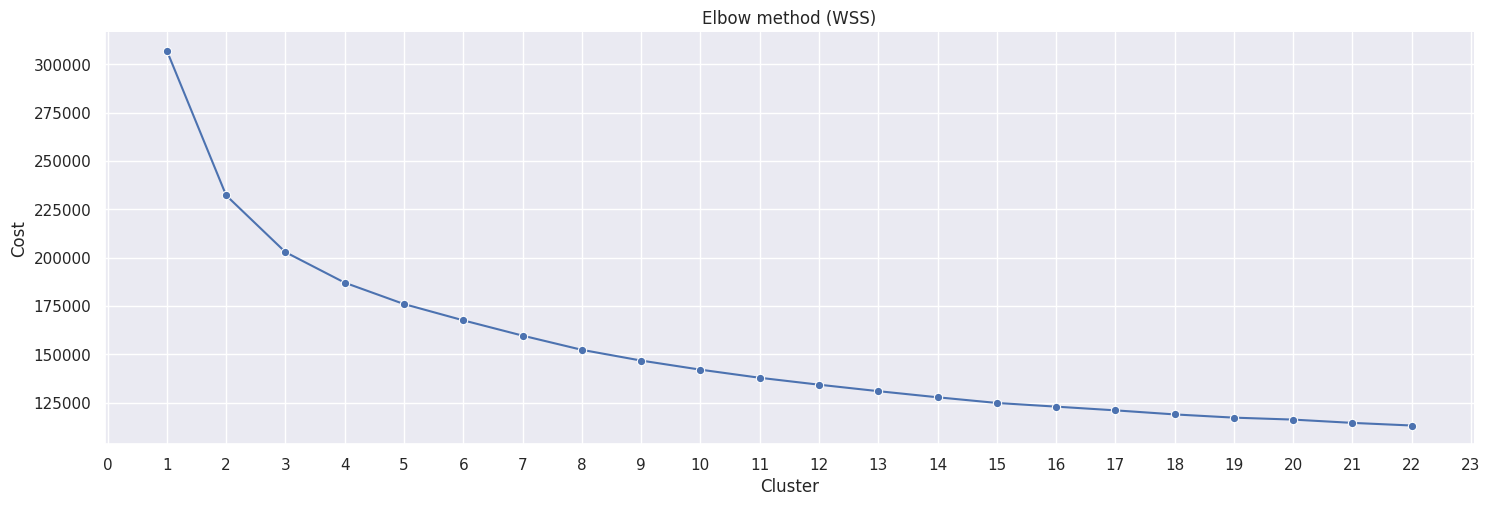

In [7]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'cluster': list(range(1, len(c_cost)+1)), 'cost': c_cost})
ax = sb.relplot(data=df_cost, x='cluster', y='cost', marker='o', kind='line', aspect=3).set(title='Elbow method (WSS)')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
ax

In [ ]:
def fast_cluster(k=1):
  model = KPrototypes(n_clusters = k, n_jobs = -2, random_state = 2247, init='Huang', max_iter=30)
  model.fit_predict(X, categorical=list(range(0, len(categorical))))
  return model

In [6]:
silhouette = []

for k in range(2,100):
    try:
        log.info("Performing clustering for k=%d", k)
        model = fast_cluster(k)
        s = silhouette_score(X=X, labels=model.labels_)
        silhouette.append(s)
        log.info("k=%d, cost=%d, n_iter=%d, score=%.4f", k, model.cost_, model.n_iter_, s)
    except KeyboardInterrupt:
        break

silhouette

[04/19/23 03:04:29] INFO     Performing clustering for k=2                                         ]8;id=36498;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=738287;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:06:43] INFO     k=2, cost=232174, n_iter=12, score=0.2611                             ]8;id=404315;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=435314;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=3                                         ]8;id=117673;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=34435;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:10:18] INFO     k=3, cost=202812, n_iter=12, score=0.1587                             ]8;id=959181;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=885580;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=4                                         ]8;id=287966;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=897859;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:15:06] INFO     k=4, cost=187008, n_iter=23, score=0.1419                             ]8;id=467237;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=427107;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=5                                         ]8;id=888562;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=154315;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:21:42] INFO     k=5, cost=175946, n_iter=19, score=0.1413                             ]8;id=894927;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=951882;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=6                                         ]8;id=996950;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=710801;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:28:31] INFO     k=6, cost=167520, n_iter=19, score=0.1404                             ]8;id=136095;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=605329;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=7                                         ]8;id=977760;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=603441;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:37:13] INFO     k=7, cost=159615, n_iter=16, score=0.1239                             ]8;id=105533;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=679275;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=8                                         ]8;id=984645;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=64410;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:46:56] INFO     k=8, cost=152260, n_iter=17, score=0.1238                             ]8;id=789311;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=607429;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=9                                         ]8;id=587693;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=133621;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 03:57:49] INFO     k=9, cost=146706, n_iter=20, score=0.1193                             ]8;id=921105;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=990548;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=10                                        ]8;id=358254;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=34800;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 04:09:13] INFO     k=10, cost=142000, n_iter=30, score=0.1203                            ]8;id=630867;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=540113;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=11                                        ]8;id=12056;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=144757;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 04:21:20] INFO     k=11, cost=137805, n_iter=28, score=0.1196                            ]8;id=817962;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=418823;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=12                                        ]8;id=657302;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=574662;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 04:35:37] INFO     k=12, cost=134230, n_iter=30, score=0.1172                            ]8;id=533161;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=751224;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=13                                        ]8;id=999074;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=775228;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 04:50:31] INFO     k=13, cost=130877, n_iter=30, score=0.1188                            ]8;id=573756;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=507632;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=14                                        ]8;id=948730;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=715314;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 05:06:58] INFO     k=14, cost=127700, n_iter=30, score=0.1194                            ]8;id=78397;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=250644;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=15                                        ]8;id=768253;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=323856;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 05:23:31] INFO     k=15, cost=125657, n_iter=22, score=0.1102                            ]8;id=493804;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=506595;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=16                                        ]8;id=710134;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=931110;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 05:41:38] INFO     k=16, cost=122698, n_iter=30, score=0.1130                            ]8;id=409323;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=923991;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=17                                        ]8;id=30543;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=723498;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 06:01:16] INFO     k=17, cost=120705, n_iter=30, score=0.1169                            ]8;id=419365;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=155550;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=18                                        ]8;id=510888;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=93904;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 06:20:49] INFO     k=18, cost=118739, n_iter=30, score=0.1170                            ]8;id=889221;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=297336;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=19                                        ]8;id=711947;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=715868;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 06:42:12] INFO     k=19, cost=117381, n_iter=30, score=0.1150                            ]8;id=993420;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=187097;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=20                                        ]8;id=910237;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=61582;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 07:05:05] INFO     k=20, cost=116014, n_iter=30, score=0.1048                            ]8;id=292014;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=791221;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=21                                        ]8;id=367118;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=490749;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 07:28:33] INFO     k=21, cost=114325, n_iter=30, score=0.1062                            ]8;id=878916;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=630827;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=22                                        ]8;id=888984;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=226206;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 07:51:50] INFO     k=22, cost=113310, n_iter=30, score=0.1034                            ]8;id=249992;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=260649;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=23                                        ]8;id=818573;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=719515;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 08:15:21] INFO     k=23, cost=111679, n_iter=30, score=0.0989                            ]8;id=276642;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=727131;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=24                                        ]8;id=489456;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=906217;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 08:39:54] INFO     k=24, cost=110606, n_iter=30, score=0.1070                            ]8;id=776493;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=217758;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=25                                        ]8;id=12347;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=263170;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 09:05:18] INFO     k=25, cost=109405, n_iter=30, score=0.1004                            ]8;id=642147;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=132807;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=26                                        ]8;id=310897;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=110807;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 09:30:16] INFO     k=26, cost=108560, n_iter=18, score=0.0955                            ]8;id=237550;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=542564;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=27                                        ]8;id=182824;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=141795;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 09:57:31] INFO     k=27, cost=107529, n_iter=30, score=0.0981                            ]8;id=589955;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=911017;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=28                                        ]8;id=748919;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=469059;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 10:26:08] INFO     k=28, cost=106140, n_iter=30, score=0.0974                            ]8;id=858846;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=275496;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=29                                        ]8;id=445356;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=358595;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 10:55:06] INFO     k=29, cost=105422, n_iter=30, score=0.0959                            ]8;id=349752;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=33665;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=30                                        ]8;id=474328;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=760051;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[04/19/23 11:25:17] INFO     k=30, cost=104131, n_iter=30, score=0.0949                            ]8;id=814880;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=714374;file:///tmp/ipykernel_1475/3711841080.py#14\14]8;;\

                    INFO     Performing clustering for k=31                                        ]8;id=826704;file:///tmp/ipykernel_1475/3711841080.py\3711841080.py]8;;\:]8;id=135675;file:///tmp/ipykernel_1475/3711841080.py#10\10]8;;\

[0.26109783372823064,
 0.15871790402467995,
 0.14190304072042226,
 0.14134437523333293,
 0.14039197249468616,
 0.12389606218799724,
 0.1237500683445814,
 0.11933109670542776,
 0.12034887671655445,
 0.11963703301758978,
 0.11719436885423093,
 0.11876205223317059,
 0.1193948740579062,
 0.11016605193962095,
 0.11301445455683042,
 0.11687981592647669,
 0.11702639979200107,
 0.11496136878953993,
 0.10484652628756294,
 0.10617183933148522,
 0.1033990596503978,
 0.0988611897451771,
 0.1070270191754991,
 0.10041806936699725,
 0.09546711890539589,
 0.09814734106653919,
 0.09735776830724621,
 0.09591741728855964,
 0.09493661173766227]

In [9]:
scores = [0.26109783372823064,
 0.15871790402467995,
 0.14190304072042226,
 0.14134437523333293,
 0.14039197249468616,
 0.12389606218799724,
 0.1237500683445814,
 0.11933109670542776,
 0.12034887671655445,
 0.11963703301758978,
 0.11719436885423093,
 0.11876205223317059,
 0.1193948740579062,
 0.11016605193962095,
 0.11301445455683042,
 0.11687981592647669,
 0.11702639979200107,
 0.11496136878953993,
 0.10484652628756294,
 0.10617183933148522,
 0.1033990596503978,
 0.0988611897451771,
 0.1070270191754991,
 0.10041806936699725,
 0.09546711890539589,
 0.09814734106653919,
 0.09735776830724621,
 0.09591741728855964,
 0.09493661173766227]

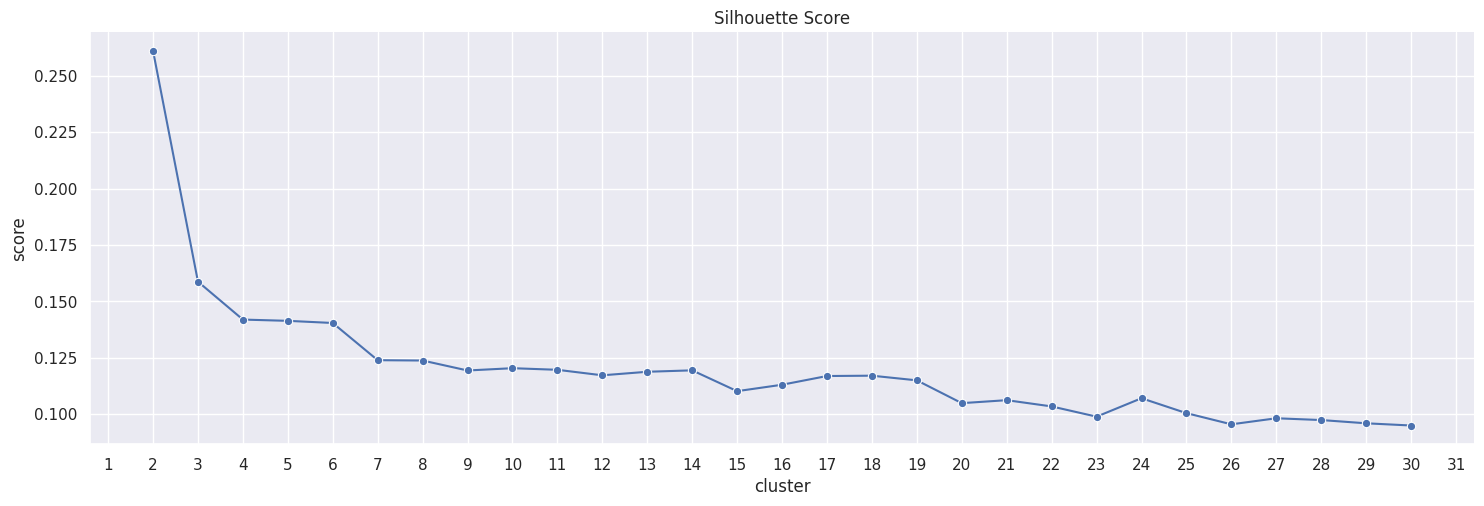

In [10]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'cluster': list(range(2, len(scores)+2)), 'score': scores})
ax = sb.relplot(data=df_cost, x='cluster', y='score', marker='o', kind='line', aspect=3).set(title='Silhouette Score')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
ax

# Summary

We select `k=4` because it has the best silhouette score (ignoring 2 and 3). One reason for the low silhouette scores could be due to the fact that the statistics for steam games such as `positive_ratings`, `median_playtime`, `achievements` are not innate modifiers of the games. They could be influenced by external factors such as media coverage, country bans, awards, or even launch of competitors (e.g. Epic Games Store) etc.

Things that could be more organic would include `budget` allocated for the game, `development team size`, `duration of development` etc.

There is also a huge spike at `k=24` which could be investigated as well.

In [ ]:
for k in [4,24]:
    try:
        log.info("Performing clustering for k=%d", k)
        model = cluster(k)
        log.info("k=%d, cost=%d, n_iter=%d", k, model.cost_, model.n_iter_)
        catalog.save(f'model@kprototypes@{k}', model)
        catalog.save(f'labels@kprototypes@{k}', pd.Series(model.labels_, name='cluster'))
    except KeyboardInterrupt:
        break